# Introduction

## Final Project Submission

***
- Student Name: Adam Marianacci
- Student Pace: Flex
- Scheduled project review date/time: TBD
- Instructor Name: Morgan Jones

# Business Understanding

Coldwell Banker wants to buy undervalued homes in certain zipcodes to minimally renovate and sell for a profit. It is my job to find homes that are being listed significanty lower than the median price and look into what variables are causing these lowered prices so that I can properly advise Coldwell Banker on which homes to target. 

# Data Understanding

This project uses the King County House Sales dataset. It contains over 30,000 entries of data related to the sale price of houses, number of bedrooms,bathrooms and floors, square footage, addresses, and more. The dataset is suitable for this project because it has enough information to reveal which homes are truly being undervalued in certain zipcodes. After analyzing the price, location, and other various specifications and amenities of homes I will be able to make informed recommendations to the real estate agency.

# Data Preperation

I started by importing the necessary libraries.

In [1]:
import pandas as pd
import re
import numpy as np
from sklearn import linear_model
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

I did not want any information in the dataframe to be truncated. I searched `pandas output truncated` in google and found this [solution](https://stackoverflow.com/questions/25351968/how-can-i-display-full-non-truncated-dataframe-information-in-html-when-conver).

In [2]:
pd.set_option("max_columns", None) # show all cols
pd.set_option('max_colwidth', None) # show full width of showing cols
pd.set_option("expand_frame_repr", False) # print cols side by side as it's supposed to be
pd.set_option('display.max_rows', 500) #show all rows

In [3]:
# Loading the dataframe
kc_house_data_df = pd.read_csv('data/kc_house_data.csv', index_col=0)

In [4]:
# Previewing the dataframe
kc_house_data_df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,condition,grade,heat_source,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long
id,,,,,,,,,,,,,,,,,,,,,,,,
7399300360,5/24/2022,675000.0,4,1.0,1180,7140,1.0,NO,NO,NO,NONE,Good,7 Average,Gas,PUBLIC,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington 98055, United States",47.461975,-122.19052
8910500230,12/13/2021,920000.0,5,2.5,2770,6703,1.0,NO,NO,YES,AVERAGE,Average,7 Average,Oil,PUBLIC,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washington 98133, United States",47.711525,-122.35591
1180000275,9/29/2021,311000.0,6,2.0,2880,6156,1.0,NO,NO,NO,AVERAGE,Average,7 Average,Gas,PUBLIC,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 98178, United States",47.502045,-122.22520
1604601802,12/14/2021,775000.0,3,3.0,2160,1400,2.0,NO,NO,NO,AVERAGE,Average,9 Better,Gas,PUBLIC,1090,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington 98118, United States",47.566110,-122.29020
8562780790,8/24/2021,592500.0,2,2.0,1120,758,2.0,NO,NO,YES,NONE,Average,7 Average,Electricity,PUBLIC,1120,550,550,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washington 98027, United States",47.532470,-122.07188


There are 24 columns and 30155 entries. There is only a handful of missing values in the "heat_source" and "sewer_system" columns. The data types consist of objects, integers, and floats.

In [5]:
# Gathering information about the datatypes within the dataframe,as well as looking for missing values
kc_house_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30155 entries, 7399300360 to 9557800100
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           30155 non-null  object 
 1   price          30155 non-null  float64
 2   bedrooms       30155 non-null  int64  
 3   bathrooms      30155 non-null  float64
 4   sqft_living    30155 non-null  int64  
 5   sqft_lot       30155 non-null  int64  
 6   floors         30155 non-null  float64
 7   waterfront     30155 non-null  object 
 8   greenbelt      30155 non-null  object 
 9   nuisance       30155 non-null  object 
 10  view           30155 non-null  object 
 11  condition      30155 non-null  object 
 12  grade          30155 non-null  object 
 13  heat_source    30123 non-null  object 
 14  sewer_system   30141 non-null  object 
 15  sqft_above     30155 non-null  int64  
 16  sqft_basement  30155 non-null  int64  
 17  sqft_garage    30155 non-null  int64

I wanted to confirm and see clearly how many missing values there were in each column.

In [6]:
kc_house_data_df.isnull().sum()

date              0
price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
waterfront        0
greenbelt         0
nuisance          0
view              0
condition         0
grade             0
heat_source      32
sewer_system     14
sqft_above        0
sqft_basement     0
sqft_garage       0
sqft_patio        0
yr_built          0
yr_renovated      0
address           0
lat               0
long              0
dtype: int64

Since there were only 32 missing values from "heat_source" and 14 missing values from "sewer_system" out of 30,155 entries, I decided to remove the rows that contained missing values. I typed `remove rows that contain missing values in a  pandas df` into google and found this [solution](https://stackoverflow.com/questions/13413590/how-to-drop-rows-of-pandas-dataframe-whose-value-in-a-certain-column-is-nan).

In [7]:
kc_house_data_df = kc_house_data_df.dropna(subset = ["heat_source", "sewer_system",])

Checking to see if my code worked, there are no more missing values.

In [8]:
kc_house_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30111 entries, 7399300360 to 9557800100
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           30111 non-null  object 
 1   price          30111 non-null  float64
 2   bedrooms       30111 non-null  int64  
 3   bathrooms      30111 non-null  float64
 4   sqft_living    30111 non-null  int64  
 5   sqft_lot       30111 non-null  int64  
 6   floors         30111 non-null  float64
 7   waterfront     30111 non-null  object 
 8   greenbelt      30111 non-null  object 
 9   nuisance       30111 non-null  object 
 10  view           30111 non-null  object 
 11  condition      30111 non-null  object 
 12  grade          30111 non-null  object 
 13  heat_source    30111 non-null  object 
 14  sewer_system   30111 non-null  object 
 15  sqft_above     30111 non-null  int64  
 16  sqft_basement  30111 non-null  int64  
 17  sqft_garage    30111 non-null  int64

"Lat", "Long", did not seem relevant since I am looking into zipcodes. I dropped them from the dataframe to simplify and condense the df.

In [9]:
kc_house_data_df.drop(['lat', 'long',], axis=1, inplace=True)

I wanted to extract zipcodes from addresses so I searched `extracting zipcodes from addresses in python` and found this [solution](https://stackoverflow.com/questions/66384707/extracting-zip-code-from-a-string-with-full-address).

In [10]:
def extract_zipcode(address):
    zipcode = re.search(r'\b\d{5}\b', address)
    if zipcode:
        return zipcode.group(0)
    else:
        return None

# Create the "Zip Code" column by applying the function to the "address" column
kc_house_data_df['Zip Code'] = kc_house_data_df['address'].apply(extract_zipcode)

In [11]:
kc_house_data_df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,condition,grade,heat_source,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,Zip Code
id,,,,,,,,,,,,,,,,,,,,,,,
7399300360,5/24/2022,675000.0,4,1.0,1180,7140,1.0,NO,NO,NO,NONE,Good,7 Average,Gas,PUBLIC,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington 98055, United States",98055
8910500230,12/13/2021,920000.0,5,2.5,2770,6703,1.0,NO,NO,YES,AVERAGE,Average,7 Average,Oil,PUBLIC,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washington 98133, United States",11231
1180000275,9/29/2021,311000.0,6,2.0,2880,6156,1.0,NO,NO,NO,AVERAGE,Average,7 Average,Gas,PUBLIC,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 98178, United States",98178
1604601802,12/14/2021,775000.0,3,3.0,2160,1400,2.0,NO,NO,NO,AVERAGE,Average,9 Better,Gas,PUBLIC,1090,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington 98118, United States",98118
8562780790,8/24/2021,592500.0,2,2.0,1120,758,2.0,NO,NO,YES,NONE,Average,7 Average,Electricity,PUBLIC,1120,550,550,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washington 98027, United States",98027


After previewing the dataset again I noticed that it was interpreting 5 digit street addresses as zipcodes. To fix this problem I decided to choose the 5 digit numbers after the word "Washington".

In [12]:
# Function to extract ZIP code after "Washington"
def extract_zipcode(address):
    match = re.search(r'Washington (\d{5})', address)
    if match:
        return match.group(1)
    return None

kc_house_data_df['Zip Code'] = kc_house_data_df['address'].apply(extract_zipcode)

In [13]:
kc_house_data_df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,condition,grade,heat_source,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,Zip Code
id,,,,,,,,,,,,,,,,,,,,,,,
7399300360,5/24/2022,675000.0,4,1.0,1180,7140,1.0,NO,NO,NO,NONE,Good,7 Average,Gas,PUBLIC,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington 98055, United States",98055
8910500230,12/13/2021,920000.0,5,2.5,2770,6703,1.0,NO,NO,YES,AVERAGE,Average,7 Average,Oil,PUBLIC,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washington 98133, United States",98133
1180000275,9/29/2021,311000.0,6,2.0,2880,6156,1.0,NO,NO,NO,AVERAGE,Average,7 Average,Gas,PUBLIC,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 98178, United States",98178
1604601802,12/14/2021,775000.0,3,3.0,2160,1400,2.0,NO,NO,NO,AVERAGE,Average,9 Better,Gas,PUBLIC,1090,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington 98118, United States",98118
8562780790,8/24/2021,592500.0,2,2.0,1120,758,2.0,NO,NO,YES,NONE,Average,7 Average,Electricity,PUBLIC,1120,550,550,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washington 98027, United States",98027


Using the nunique function to find the number of zipcodes in the dataset which is 92.

In [14]:
unique_zipcodes = kc_house_data_df['Zip Code'].nunique()

In [15]:
unique_zipcodes

92

# Data Analysis

I started by running a df.describe() on the dataset to learn more about the descriptive statistics.

In [16]:
kc_house_data_df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated
count,3.011100e+04,30111.000000,30111.000000,30111.000000,3.011100e+04,30111.000000,30111.000000,30111.000000,30111.000000,30111.000000,30111.000000,30111.000000
mean,1.108971e+06,3.415197,2.335708,2113.342798,1.664880e+04,1.543506,1810.389658,476.617117,330.475308,217.451264,1975.162299,90.792767
std,8.965158e+05,0.979755,0.888293,973.453260,5.993303e+04,0.567789,877.726339,579.805355,285.725020,245.301991,32.052930,416.197627
min,2.736000e+04,0.000000,0.000000,3.000000,4.020000e+02,1.000000,2.000000,0.000000,0.000000,0.000000,1900.000000,0.000000
25%,6.492360e+05,3.000000,2.000000,1420.000000,4.850000e+03,1.000000,1180.000000,0.000000,0.000000,40.000000,1953.000000,0.000000
50%,8.600000e+05,3.000000,2.500000,1920.000000,7.477000e+03,1.500000,1560.000000,0.000000,400.000000,150.000000,1977.000000,0.000000
75%,1.300000e+06,4.000000,3.000000,2620.000000,1.056800e+04,2.000000,2270.000000,940.000000,510.000000,320.000000,2003.000000,0.000000
max,3.075000e+07,13.000000,10.500000,15360.000000,3.253932e+06,4.000000,12660.000000,8020.000000,3580.000000,4370.000000,2022.000000,2022.000000


<AxesSubplot:>

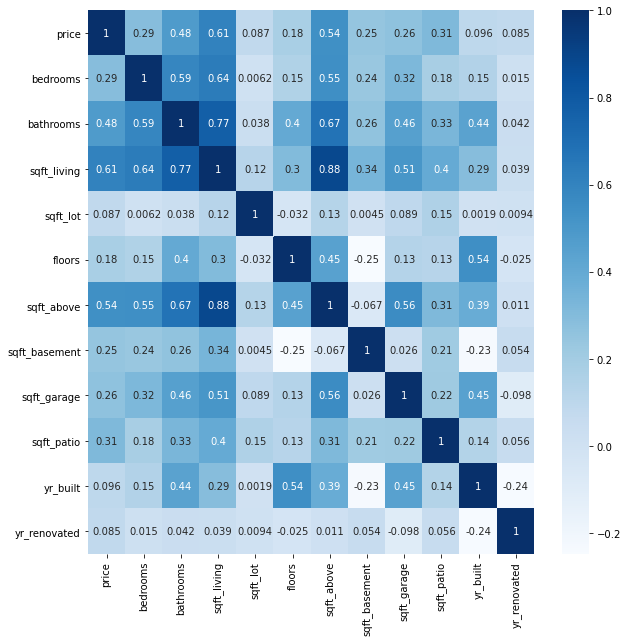

In [17]:
fig, ax = plt.subplots(figsize=(10,10))
cor = kc_house_data_df.corr()
sns.heatmap(cor,cmap="Blues",annot=True)

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

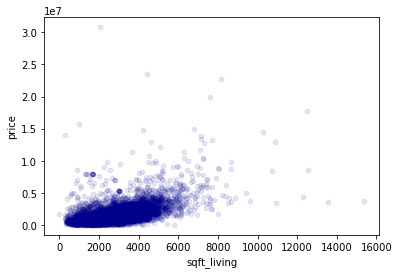

In [18]:
kc_house_data_df.plot.scatter(
    x='sqft_living',
    y='price',
    c='DarkBlue',
    alpha = 0.1)

I wanted to see how many zipcodes there were in the dataset and how many each contained so I ran a value_counts on "Zip Codes"

In [19]:
kc_house_data_df['Zip Code'].value_counts()

98042    992
98038    857
98103    761
98115    760
98117    748
98023    695
98034    689
98058    682
98133    664
98001    623
98092    609
98033    608
98118    600
98059    583
98052    568
98106    543
98031    530
98006    526
98056    520
98155    515
98125    489
98045    466
98107    458
98022    457
98003    440
98126    440
98122    440
98144    439
98146    428
98074    427
98198    425
98075    411
98199    410
98008    397
98053    393
98116    387
98168    383
98178    383
98027    382
98030    377
98002    363
98040    349
98028    349
98166    344
98072    343
98105    330
98004    322
98029    321
98010    314
98112    307
98108    305
98177    301
98136    299
98065    292
98011    261
98077    246
98019    245
98119    241
98055    218
98188    200
98070    191
98032    184
98005    178
98014    156
98007    154
98102    144
98109    129
98057    127
98024    114
98148     94
98047     77
98051     66
98039     59
98354     23
98288     16
98272      6
98271      5

After reviewing the counts, I decided to the drop the zipcodes that had under 100 houses listed to sale. I decided to keep the '98149' zipcode with a count of 94 because it was close.

In [20]:
# Count the occurrences of each ZIP code
zipcode_counts = kc_house_data_df['Zip Code'].value_counts()
kc_house_data_df = kc_house_data_df[kc_house_data_df['Zip Code'].isin(zipcode_counts[zipcode_counts >= 94].index)]


Checking to see if the Zip Codes below a count of 94 were dropped, they were!

In [21]:
kc_house_data_df['Zip Code'].value_counts()

98042    992
98038    857
98103    761
98115    760
98117    748
98023    695
98034    689
98058    682
98133    664
98001    623
98092    609
98033    608
98118    600
98059    583
98052    568
98106    543
98031    530
98006    526
98056    520
98155    515
98125    489
98045    466
98107    458
98022    457
98003    440
98122    440
98126    440
98144    439
98146    428
98074    427
98198    425
98075    411
98199    410
98008    397
98053    393
98116    387
98168    383
98178    383
98027    382
98030    377
98002    363
98028    349
98040    349
98166    344
98072    343
98105    330
98004    322
98029    321
98010    314
98112    307
98108    305
98177    301
98136    299
98065    292
98011    261
98077    246
98019    245
98119    241
98055    218
98188    200
98070    191
98032    184
98005    178
98014    156
98007    154
98102    144
98109    129
98057    127
98024    114
98148     94
Name: Zip Code, dtype: int64

I wanted to create a graph of median prices of homes by zipcode to get an idea of which zipcodes had the highest median price. To do this I used the sort_values function along with the median function. 

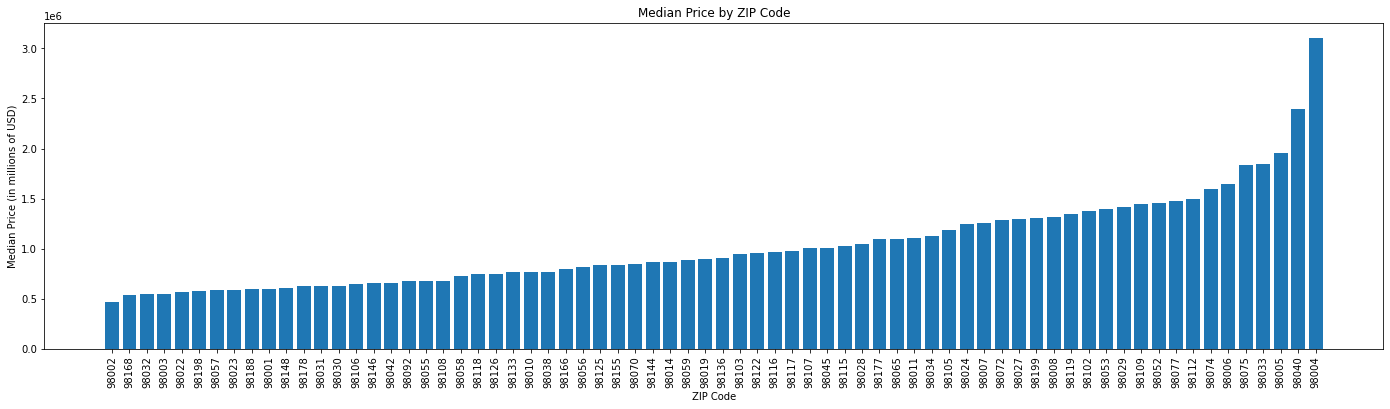

In [22]:
# Group data by ZIP code and calculate the median price from lowest to highest
median_prices = kc_house_data_df.groupby('Zip Code')['price'].median().sort_values().reset_index()

# Create a bar chart to visualize the median prices by ZIP code
plt.figure(figsize=(24, 6))
plt.bar(median_prices['Zip Code'], median_prices['price'])
plt.xlabel('ZIP Code')
plt.ylabel('Median Price (in millions of USD)')
plt.title('Median Price by ZIP Code')
# Label every data point on the X-axis
plt.xticks(range(len(median_prices)), median_prices['Zip Code'], rotation=90)


plt.show()


In [23]:
overall_median_price = kc_house_data_df['price'].median()
print("Overall Median Price:", overall_median_price)


Overall Median Price: 870000.0


I wanted to know what the Median Price of homes is in the Kings County dataset - It is $870,000. Now I want to investigate which zip codes have a lot of homes for sale significantly below the median price for the county.I started by gathering the zipcodes that below the median price for the county.

In [24]:
low_median_prices = median_prices[median_prices['price']<870000]

I decided to create a new dataframe that consisted of all the zipcodes that were below the median price of $870,000 for the county.

In [25]:
low_kc_house = kc_house_data_df[kc_house_data_df['Zip Code'].isin(low_median_prices['Zip Code'])]

In [26]:
low_kc_house

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,condition,grade,heat_source,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,Zip Code
id,,,,,,,,,,,,,,,,,,,,,,,
7399300360,5/24/2022,675000.0,4,1.0,1180,7140,1.0,NO,NO,NO,NONE,Good,7 Average,Gas,PUBLIC,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington 98055, United States",98055
8910500230,12/13/2021,920000.0,5,2.5,2770,6703,1.0,NO,NO,YES,AVERAGE,Average,7 Average,Oil,PUBLIC,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washington 98133, United States",98133
1180000275,9/29/2021,311000.0,6,2.0,2880,6156,1.0,NO,NO,NO,AVERAGE,Average,7 Average,Gas,PUBLIC,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 98178, United States",98178
1604601802,12/14/2021,775000.0,3,3.0,2160,1400,2.0,NO,NO,NO,AVERAGE,Average,9 Better,Gas,PUBLIC,1090,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington 98118, United States",98118
2807100156,7/20/2021,625000.0,2,1.0,1190,5688,1.0,NO,NO,YES,NONE,Average,7 Average,Electricity,PUBLIC,1190,0,300,0,1948,0,"1602 North 185th Street, Shoreline, Washington 98133, United States",98133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3277800805,9/17/2021,725000.0,3,1.0,1680,3249,1.5,NO,NO,NO,NONE,Average,7 Average,Oil,PUBLIC,1380,880,240,0,1929,0,"6324 34th Avenue Southwest, Seattle, Washington 98126, United States",98126
3915500105,12/3/2021,380000.0,3,1.0,860,7805,1.0,NO,NO,YES,NONE,Good,6 Low Average,Gas,PUBLIC,860,0,0,0,1947,0,"407 M Street Southeast, Auburn, Washington 98002, United States",98002
2865600230,2/28/2022,665000.0,3,2.5,2100,7210,2.0,NO,NO,NO,NONE,Good,7 Average,Gas,PUBLIC,2100,0,440,40,1979,0,"5218 South 302nd Place, Auburn, Washington 98001, United States",98001


In [27]:
low_kc_house['grade'].value_counts()

7 Average        6642
8 Good           3991
6 Low Average    2142
9 Better         1051
5 Fair            279
10 Very Good      230
11 Excellent       50
4 Low              32
3 Poor              8
12 Luxury           5
2 Substandard       1
Name: grade, dtype: int64

Since the 'grade' column contained categorical data I wanted to change this to numerical data so it could be useful once I start modeling. I used the .map function and found information on this by typing `map a function to a column in pandas` and found this [solution](https://sparkbyexamples.com/pandas/pandas-map-function-explained/)

In [28]:
grade_mapping = {
    '2 Substandard': 2,
    '3 Poor': 3,
    '4 Low': 4,
    '5 Fair': 5,
    '6 Low Average': 6,
    '7 Average': 7,
    '8 Good': 8,
    '9 Better': 9,
    '10 Very Good': 10,
    '11 Excellent': 11,
    '12 Luxury': 12,
}

low_kc_house['grade'] = low_kc_house['grade'].map(grade_mapping)



I wanted to check my data type on the grade column to make sure it was now numerical data by running .info on the df and it is.

In [29]:
low_kc_house

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,condition,grade,heat_source,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,Zip Code
id,,,,,,,,,,,,,,,,,,,,,,,
7399300360,5/24/2022,675000.0,4,1.0,1180,7140,1.0,NO,NO,NO,NONE,Good,7,Gas,PUBLIC,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington 98055, United States",98055
8910500230,12/13/2021,920000.0,5,2.5,2770,6703,1.0,NO,NO,YES,AVERAGE,Average,7,Oil,PUBLIC,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washington 98133, United States",98133
1180000275,9/29/2021,311000.0,6,2.0,2880,6156,1.0,NO,NO,NO,AVERAGE,Average,7,Gas,PUBLIC,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 98178, United States",98178
1604601802,12/14/2021,775000.0,3,3.0,2160,1400,2.0,NO,NO,NO,AVERAGE,Average,9,Gas,PUBLIC,1090,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington 98118, United States",98118
2807100156,7/20/2021,625000.0,2,1.0,1190,5688,1.0,NO,NO,YES,NONE,Average,7,Electricity,PUBLIC,1190,0,300,0,1948,0,"1602 North 185th Street, Shoreline, Washington 98133, United States",98133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3277800805,9/17/2021,725000.0,3,1.0,1680,3249,1.5,NO,NO,NO,NONE,Average,7,Oil,PUBLIC,1380,880,240,0,1929,0,"6324 34th Avenue Southwest, Seattle, Washington 98126, United States",98126
3915500105,12/3/2021,380000.0,3,1.0,860,7805,1.0,NO,NO,YES,NONE,Good,6,Gas,PUBLIC,860,0,0,0,1947,0,"407 M Street Southeast, Auburn, Washington 98002, United States",98002
2865600230,2/28/2022,665000.0,3,2.5,2100,7210,2.0,NO,NO,NO,NONE,Good,7,Gas,PUBLIC,2100,0,440,40,1979,0,"5218 South 302nd Place, Auburn, Washington 98001, United States",98001


In [30]:
low_kc_house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14431 entries, 7399300360 to 9557800100
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           14431 non-null  object 
 1   price          14431 non-null  float64
 2   bedrooms       14431 non-null  int64  
 3   bathrooms      14431 non-null  float64
 4   sqft_living    14431 non-null  int64  
 5   sqft_lot       14431 non-null  int64  
 6   floors         14431 non-null  float64
 7   waterfront     14431 non-null  object 
 8   greenbelt      14431 non-null  object 
 9   nuisance       14431 non-null  object 
 10  view           14431 non-null  object 
 11  condition      14431 non-null  object 
 12  grade          14431 non-null  int64  
 13  heat_source    14431 non-null  object 
 14  sewer_system   14431 non-null  object 
 15  sqft_above     14431 non-null  int64  
 16  sqft_basement  14431 non-null  int64  
 17  sqft_garage    14431 non-null  int64

I dropped date because it was not a useful column of numeric values.

In [31]:
# Drop columns 'date'
low_kc_house.drop(columns=['date'], inplace=True)

Taking a look at what variables had the highest correlation with price.

In [32]:
low_kc_house.corr()['price']

price            1.000000
bedrooms         0.243354
bathrooms        0.392516
sqft_living      0.515232
sqft_lot         0.164922
floors           0.217318
grade            0.464651
sqft_above       0.422674
sqft_basement    0.222079
sqft_garage      0.181194
sqft_patio       0.272113
yr_built         0.104482
yr_renovated     0.080330
Name: price, dtype: float64

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

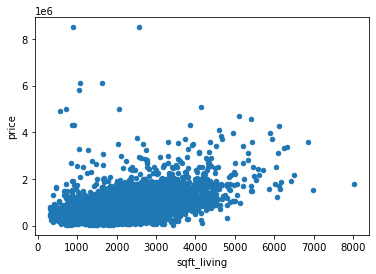

In [33]:
low_kc_house.plot.scatter(x='sqft_living', y='price')

Starting the train test split process. I entered my numerical features as my X variables and 'price' against my y variable.

In [34]:
# Define the features (X) and the target variable (y)
X = low_kc_house[['sqft_living','bedrooms','bathrooms','floors','grade','sqft_lot','sqft_above','sqft_garage','sqft_basement','sqft_patio']]
y = low_kc_house['price']


In [35]:
# split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [66]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(11544, 10)
(2887, 10)
(11544,)
(2887,)


In [36]:
X.dtypes

sqft_living        int64
bedrooms           int64
bathrooms        float64
floors           float64
grade              int64
sqft_lot           int64
sqft_above         int64
sqft_garage        int64
sqft_basement      int64
sqft_patio         int64
dtype: object

# Modeling

In [37]:
#Create a Linear Regression Model
lr = LinearRegression()

In [38]:
lr.fit(X_train, y_train)

LinearRegression()

In [39]:
# Predict on the testing set
# Y_preds are predicted values of the target variable based on the features
# Once we have those preds, we can compare them to the actual values of the target
# To evaluate the performance of the model
y_pred = lr.predict(X_test)

In [40]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Evaluate the performance of the model
#R2: variance of the dependent variable, how well the model fits the data.
r2 = r2_score(y_test, y_pred) 
#MSE: average squared distance between the predicted and actual values. Lower is better.
rmse = mean_squared_error(y_test, y_pred,squared = False)
#MAE: average absolute distance between the predicted and actual values. Lower is better.
mae = mean_absolute_error(y_test, y_pred)
#Intercept: starting point of the regression line on the y-axis.
#value of the dependent variable (target) when the independent variables (features) are zero.
intercept = lr.intercept_

print("R2 score: ", r2)
print("Root Mean Squared Error: ", rmse)
print("Mean Absolute Error: ", mae)
print("Intercept: ", intercept)
 

R2 score:  0.35144510605769796
Root Mean Squared Error:  312227.4216825794
Mean Absolute Error:  176236.20491543403
Intercept:  -212239.64995935524


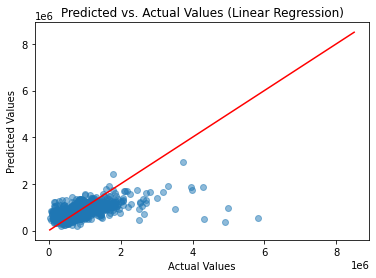

In [41]:
# Plot the predicted vs. actual values

plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color ="red")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. Actual Values (Linear Regression)")
plt.show()

Building a baseline (Simple Linear Regression) model.

In [42]:
baseline_model = sm.OLS(endog=y_train, exog=sm.add_constant(X_train['sqft_living']))
baseline_model

In [43]:
results = baseline_model.fit()
results

In [45]:
results.pvalues

const          1.237587e-246
sqft_living     0.000000e+00
dtype: float64

Both of the model parameters(coeffecient for sqft_living and intercept) are statistically significant, with p-values below the standard alpha of 0.05.

In [46]:
print(results.conf_int())

                         0              1
const        255033.338985  285877.381177
sqft_living     236.027221     250.902630


The 95% confidence interval for the intercept is about 252282.6 to about 280032.4. The 95% confidence interval for the coeffecient of sqft_living is about 239.1 to about 252.5.

In [47]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     4117.
Date:                Tue, 07 Nov 2023   Prob (F-statistic):               0.00
Time:                        12:33:47   Log-Likelihood:            -1.6271e+05
No. Observations:               11544   AIC:                         3.254e+05
Df Residuals:                   11542   BIC:                         3.254e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2.705e+05   7867.698     34.375      0.000    2.55e+05    2.86e+05
sqft_living   243.4649      3.794     64.164      0.000     236.027     250.903
==============================================================================
Omnibus:                    13605.835   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4328467.790
Skew:                           5.844   Prob(JB):                         0.00
Kurtosis:                      97.140   Cond. No.                     5.48e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.48e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The model explains about 26% of the variance.
The model predicts that an increase of 1 sqft_living is associated with an increase of about $245 in price.
The model is statistically significant with a p-value below the standard alpha of 0.05

Building a Multiple Linear Regression Model 

In [59]:
X_train[['sqft_living', 'grade']]

,sqft_living,grade
id,,
7300400840,3120,9
3327900100,1800,7
9558020820,1900,8
3224049105,2420,7
4058801085,3110,8
...,...,...
7305300800,1200,6
520079082,3510,9
722069226,2990,7


In [63]:
X = low_kc_house[['sqft_living','bedrooms','bathrooms','floors','grade','sqft_lot','sqft_above','sqft_garage','sqft_basement','sqft_patio']]
X_second = low_kc_house[['sqft_living', 'grade']]
y = low_kc_house['price']

In [64]:
MLR_model = sm.OLS(y_train, X_train[['sqft_living', 'grade']])
second_results = MLR_model.fit()
print(second_results.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.854
Model:                            OLS   Adj. R-squared (uncentered):              0.854
Method:                 Least Squares   F-statistic:                          3.378e+04
Date:                Tue, 07 Nov 2023   Prob (F-statistic):                        0.00
Time:                        14:54:31   Log-Likelihood:                     -1.6256e+05
No. Observations:               11544   AIC:                                  3.251e+05
Df Residuals:                   11542   BIC:                                  3.251e+05
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [67]:
# Predict on the testing set
# Y_preds are predicted values of the target variable based on the features
# Once we have those preds, we can compare them to the actual values of the target
# To evaluate the performance of the model
y_pred = second_results.predict(X_test[['sqft_living', 'grade']])

In [68]:
# Evaluate the performance of the model
#R2: variance of the dependent variable, how well the model fits the data.
r2 = r2_score(y_test, y_pred) 
#MSE: average squared distance between the predicted and actual values. Lower is better.
rmse = mean_squared_error(y_test, y_pred,squared = False)
#MAE: average absolute distance between the predicted and actual values. Lower is better.
mae = mean_absolute_error(y_test, y_pred)
#Intercept: starting point of the regression line on the y-axis.
#value of the dependent variable (target) when the independent variables (features) are zero.
intercept = lr.intercept_

print("R2 score: ", r2)
print("Root Mean Squared Error: ", rmse)
print("Mean Absolute Error: ", mae)
print("Intercept: ", intercept)
 

R2 score:  0.2928359042825103
Root Mean Squared Error:  326030.15733938135
Mean Absolute Error:  185517.50406159274
Intercept:  -212239.64995935524


In [51]:
#This model explains about 28.9% of the variance.


In [55]:
X = low_kc_house[['sqft_living','bedrooms','bathrooms','floors','grade','sqft_lot','sqft_above','sqft_garage','sqft_basement','sqft_patio']]
y = low_kc_house['price']

Building a third model with all numeric features

In [70]:
MLR_model2 = sm.OLS(y_train, X_train)
third_results = MLR_model2.fit()
print(third_results.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.863
Model:                            OLS   Adj. R-squared (uncentered):              0.863
Method:                 Least Squares   F-statistic:                              7289.
Date:                Tue, 07 Nov 2023   Prob (F-statistic):                        0.00
Time:                        16:19:55   Log-Likelihood:                     -1.6218e+05
No. Observations:               11544   AIC:                                  3.244e+05
Df Residuals:                   11534   BIC:                                  3.244e+05
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

In [71]:
# Predict on the testing set
# Y_preds are predicted values of the target variable based on the features
# Once we have those preds, we can compare them to the actual values of the target
# To evaluate the performance of the model
y_pred = third_results.predict(X_test)

In [72]:
# Evaluate the performance of the model
#R2: variance of the dependent variable, how well the model fits the data.
r2 = r2_score(y_test, y_pred) 
#MSE: average squared distance between the predicted and actual values. Lower is better.
rmse = mean_squared_error(y_test, y_pred,squared = False)
#MAE: average absolute distance between the predicted and actual values. Lower is better.
mae = mean_absolute_error(y_test, y_pred)
#Intercept: starting point of the regression line on the y-axis.
#value of the dependent variable (target) when the independent variables (features) are zero.
intercept = lr.intercept_

print("R2 score: ", r2)
print("Root Mean Squared Error: ", rmse)
print("Mean Absolute Error: ", mae)
print("Intercept: ", intercept)

R2 score:  0.3473016388524601
Root Mean Squared Error:  313223.20814155496
Mean Absolute Error:  176149.00097037255
Intercept:  -212239.64995935524


# Conclusion